**HW 3: Model Evaluation and Hyperparameter Tuning**

In [ ]:
#Importing libraries
import numpy as np
import pandas as pd
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, f1_score, roc_curve, auc, precision_recall_fscore_support
from sklearn.metrics import precision_score, recall_score, roc_auc_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix


In [ ]:
#laoding in datasets, split and train
data = load_breast_cancer()
X, y = data.data, data.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#standardizing features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

#setting up hyperparameter grids for GridSearchCV
param_grid_dt = {'max_depth': [3, 5, 10, None], 'min_samples_split': [2, 10, 20], 'min_samples_leaf': [1, 5, 10]}
param_grid_rf = {'n_estimators': [50, 100, 200], 'max_depth': [None, 10, 20], 'min_samples_split': [2, 10], 'min_samples_leaf': [1, 5]}
param_grid_knn = {'n_neighbors': [3, 5, 7, 9], 'weights': ['uniform', 'distance'], 'p': [1, 2]}

**Model Building**

In [ ]:
#initizalize models
dt = DecisionTreeClassifier()
rf = RandomForestClassifier()
knn = KNeighborsClassifier()

# Hyperparameter tuning with GridSearchCV
#set up decision tree grid search
grid_search_dt = GridSearchCV(dt, param_grid_dt, cv=5, scoring='f1')
grid_search_dt.fit(X_train, y_train)
dt_best = grid_search_dt.best_estimator_

In [ ]:
#random forest grid search
grid_search_rf = GridSearchCV(rf, param_grid_rf, cv=5, scoring='f1')
grid_search_rf.fit(X_train, y_train)
rf_best = grid_search_rf.best_estimator_

#K-Nearest neighbors search
grid_search_knn = GridSearchCV(knn, param_grid_knn, cv=5, scoring='f1')
grid_search_knn.fit(X_train, y_train)
knn_best = grid_search_knn.best_estimator_

#evaluating models by cross validation
def evaluate_model(model, X, y):
    accuracy = cross_val_score(model, X, y, cv=5, scoring='accuracy')
    f1 = cross_val_score(model, X, y, cv=5, scoring='f1')
    precision = cross_val_score(model, X, y, cv=5, scoring='precision')
    recall = cross_val_score(model, X, y, cv=5, scoring='recall')
    auc = cross_val_score(model, X, y, cv=5, scoring='roc_auc')
    
    #calculating specificity
    specificity_scores = []
    for train_idx, test_idx in StratifiedKFold(n_splits=5).split(X, y):
        model.fit(X[train_idx], y[train_idx])
        y_pred = model.predict(X[test_idx])
        tn, fp, fn, tp = confusion_matrix(y[test_idx], y_pred).ravel()
        specificity = tn / (tn + fp)
        specificity_scores.append(specificity)
    
    return accuracy, f1, precision, recall, specificity_scores, auc

dt_metrics = evaluate_model(dt_best, X_train, y_train)
rf_metrics = evaluate_model(rf_best, X_train, y_train)
knn_metrics = evaluate_model(knn_best, X_train, y_train)

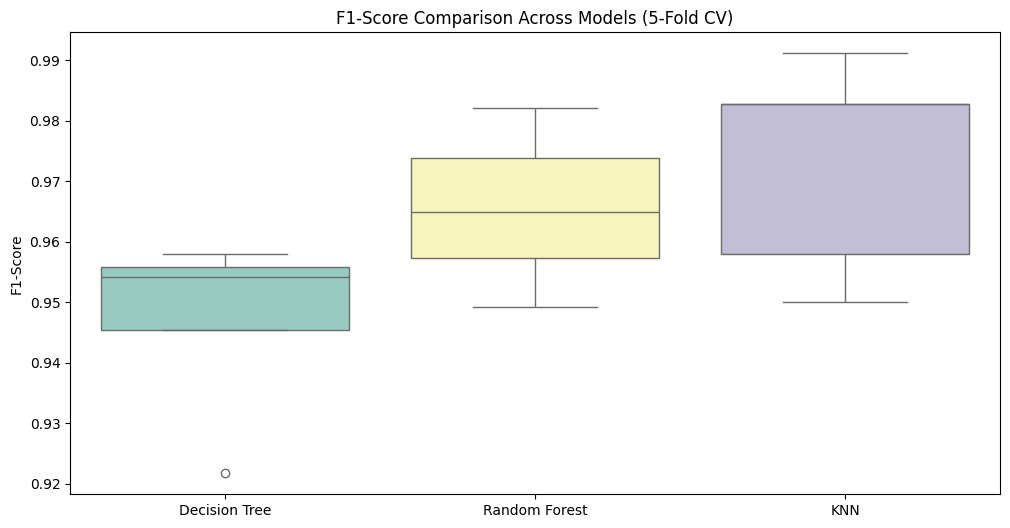

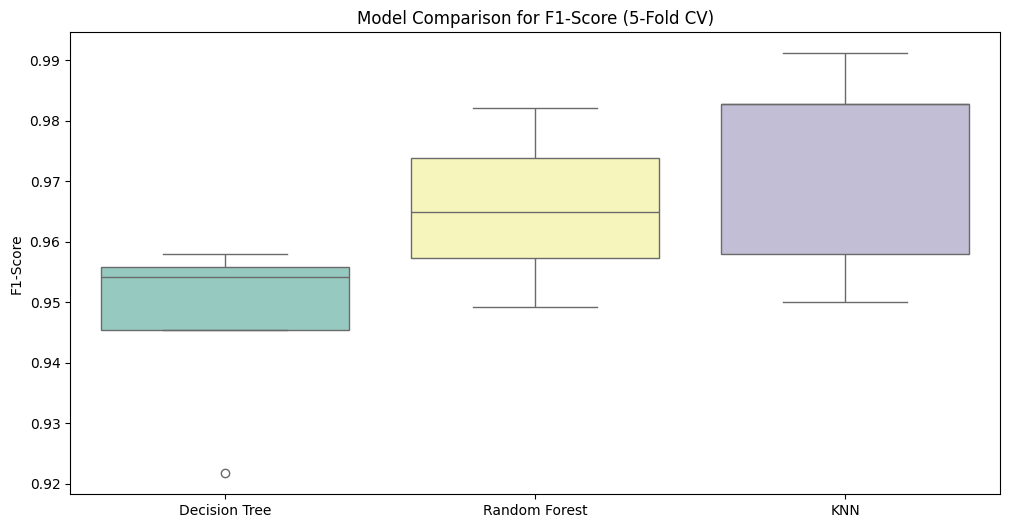

In [ ]:
#extract F1-scores from the evaluation results
dt_f1 = dt_metrics[1] 
rf_f1 = rf_metrics[1] 
knn_f1 = knn_metrics[1]

#plot performance metrics
#plot boxplots
plt.figure(figsize=(12, 6))
sns.boxplot(data=[dt_f1, rf_f1, knn_f1], palette='Set3')
plt.title("F1-Score Comparison Across Models (5-Fold CV)")
plt.xticks([0, 1, 2], ['Decision Tree', 'Random Forest', 'KNN'])
plt.ylabel('F1-Score')
plt.show()


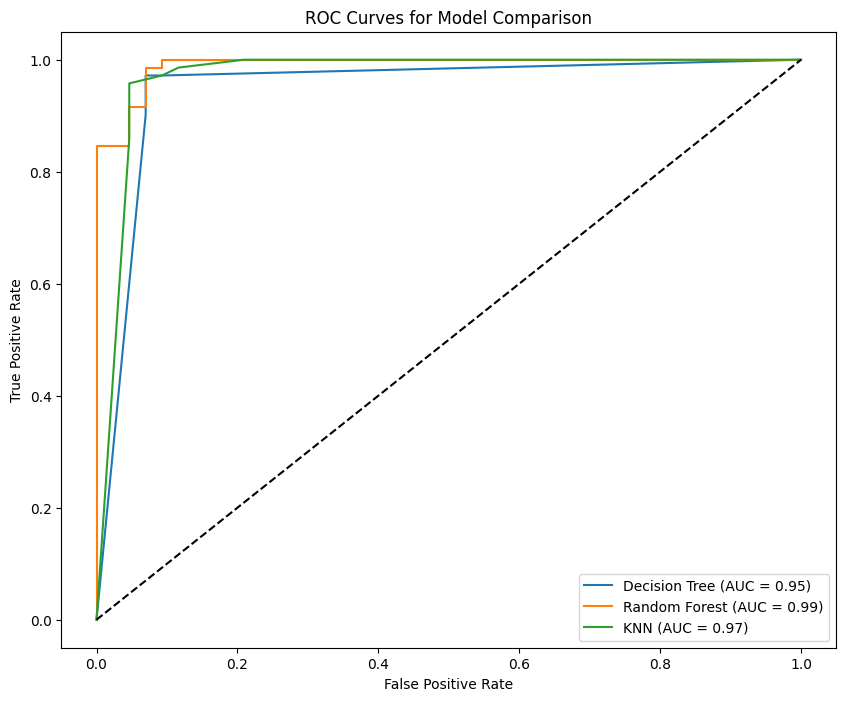

In [ ]:
#ROC Curves
def plot_roc_curve(model, X_test, y_test, label):
    y_pred_prob = model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{label} (AUC = {roc_auc:.2f})')

plt.figure(figsize=(10, 8))
plot_roc_curve(dt_best, X_test, y_test, 'Decision Tree')
plot_roc_curve(rf_best, X_test, y_test, 'Random Forest')
plot_roc_curve(knn_best, X_test, y_test, 'KNN')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Model Comparison')
plt.legend(loc='lower right')
plt.show()

After evaluating the models, **Random Forest Model** seems to be the best preforming model. It consistently has high scores across multiple metrics—especially F1-score, accuracy, and AUC. 

**Influence of Hyperparameter Tuning**
- Random Forest: Hyperparameter tuning, the number of trees and maximum depth, allowed the model to balance between underfitting and overfitting, maximizing its F1-score and overall performance.
- KNN: The choice of n_neighbors significantly impacted KNN’s performance. By tuning this parameter, the model was adjusted to better capture local patterns in the data.
- Decision Tree: Tuning the depth of the tree helped prevent overfitting, but the single-tree structure limited its flexibiliy.

**Impact of Model Evaluation Techniques**
- Cross validation: This helped mitigate variability due to data splits by averaging performance over multiple folds. Tis really helped to ensure that the models’ results were more generalizable.
- ROC Curves and AUC: Evaluating AUC scores allowed me to compare how well each model distinguishe between classes.